In [1]:
import sys
import os
import PIL.Image
import PIL.ImageFilter
from PIL.ImageFilter import (FIND_EDGES)

import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load reCAPTCHA dataset
size = (64, 64)
img_folder = "D:/Informatiekunde/MLP_Final_Project/images/"

img_data_array = []
class_name=[]
for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
        image_path = os.path.join(img_folder, dir1,  file)
        image = np.array(PIL.Image.open(image_path).convert('RGB').resize(size).filter(FIND_EDGES))
        image = image.astype('float32')
        image /= 255
        img_data_array.append(image)
        class_name.append(dir1)

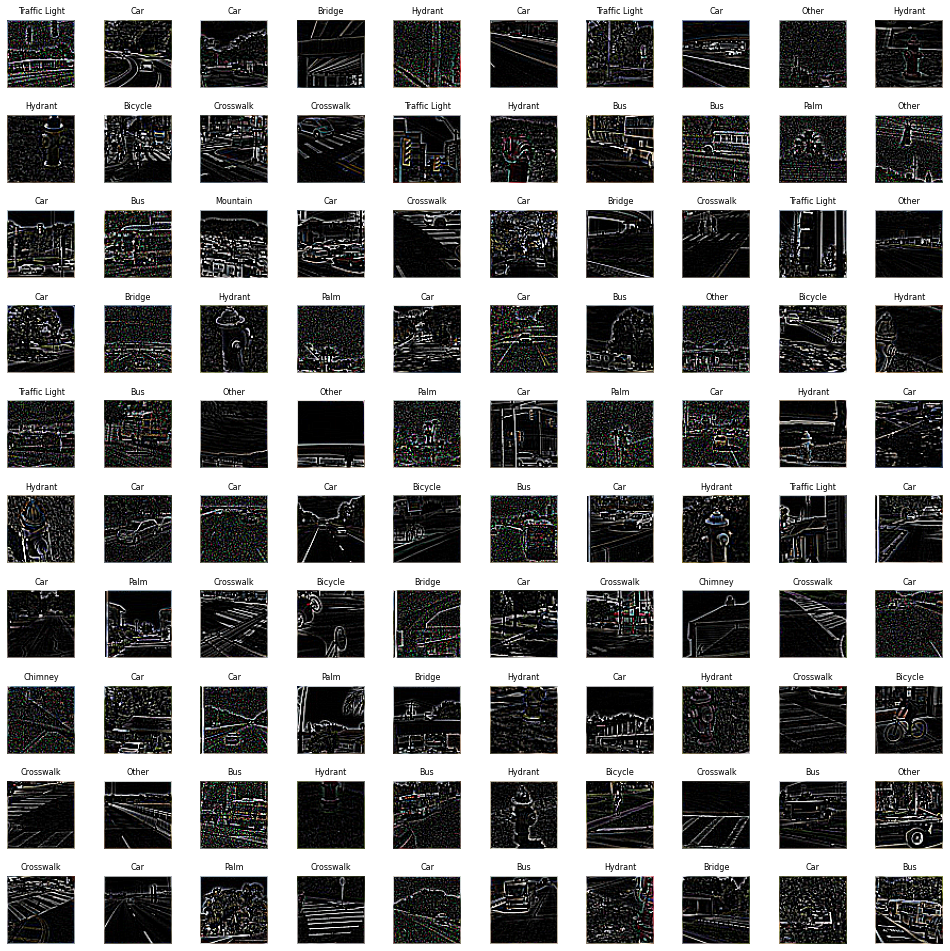

In [3]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(img_data_array) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(img_data_array[index])
    label = class_name[index]
    axes[i].set_title(label, fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in reCAPTCHA dataset')

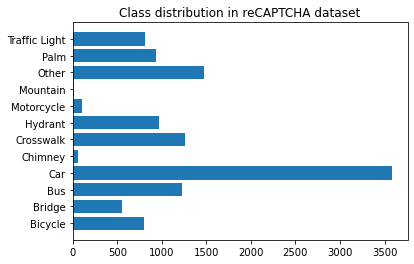

In [4]:
# Show label distribution
classes, counts = np.unique(class_name, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in reCAPTCHA dataset')

In [5]:
print(type(img_data_array))

<class 'list'>


In [6]:
# We see that Mountain, Motorcycle and Chimney labels are under represented and thus we decide to remove them from the dataset
d = {'Image':img_data_array, 'Label':class_name}
df = pd.DataFrame(d)

df_filtered = df[(df['Label'] != 'Mountain') & (df['Label'] != 'Motorcycle') & (df['Label'] != 'Chimney') & (df['Label'] != 'Other')]

# The Car labels are over represented in the dataset and thus we decide to remove 2000 entries of Cars to even it out with the rest
car_index = df_filtered.index[df_filtered['Label'] == 'Car'].tolist()

df_new = df_filtered.drop(df_filtered.index[car_index[:2400]])

Text(0.5, 1.0, 'Class distribution in reCAPTCHA dataset')

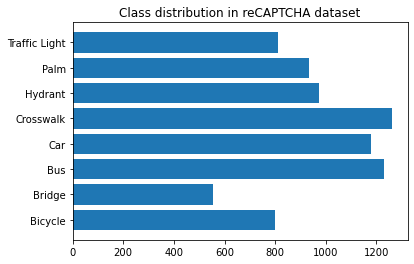

In [7]:
# Convert the dataframe columns back to lists
image_dataset = df_new['Image'].to_list()
label_dataset = df_new['Label'].to_list()

# Show new label distribution
classes, counts = np.unique(label_dataset, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in reCAPTCHA dataset')

In [8]:
# Extract unique labels
labels = np.unique(label_dataset)

# Convert categorical labels into one hot encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(label_dataset)

# Binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels_onehot_dataset = onehot_encoder.fit_transform(integer_encoded)

In [9]:
# Split dataset into training and test set
x_train, x_test, y_train, y_test = train_test_split(image_dataset, labels_onehot_dataset, test_size=0.2, random_state=10)

In [10]:
model = Sequential()
layer_image_size = 64

# Learns local patterns from image
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Simplify information given by the convulational layer by extracting most important features
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), input_shape=(layer_image_size, layer_image_size, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Converting pooling map into one dimensional vector
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                        

In [12]:
# batch_size = 32
# data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# train_generator = data_generator.flow(x_train, y_train, batch_size)
# steps_per_epoch = x_train.shape[0] // batch_size

x_train = np.array(x_train)
x_test = np.array(x_test)

In [13]:
total_evaluation = 0
for i in range(5):
    r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)
    evaluation = model.evaluate(x_test, y_test)
    total_evaluation += evaluation[1]
accuracy = total_evaluation / 5
print(accuracy)

Epoch 1/3
194/194 [==============================] - 7s 19ms/step - loss: 1.9118 - accuracy: 0.3439 - precision: 0.5267 - recall: 0.1403 - val_loss: 2.9681 - val_accuracy: 0.1545 - val_precision: 0.1547 - val_recall: 0.1545
Epoch 2/3
194/194 [==============================] - 3s 14ms/step - loss: 1.3112 - accuracy: 0.5231 - precision: 0.6899 - recall: 0.3605 - val_loss: 2.4629 - val_accuracy: 0.2282 - val_precision: 0.3100 - val_recall: 0.1319
Epoch 3/3
49/49 [==============================] - 0s 5ms/step - loss: 1.4217 - accuracy: 0.5107 - precision: 0.6088 - recall: 0.3833
Epoch 1/3
194/194 [==============================] - 3s 15ms/step - loss: 0.9174 - accuracy: 0.6763 - precision: 0.7735 - recall: 0.5640 - val_loss: 1.0762 - val_accuracy: 0.6251 - val_precision: 0.7158 - val_recall: 0.5339
Epoch 2/3
194/194 [==============================] - 3s 15ms/step - loss: 0.8355 - accuracy: 0.7017 - precision: 0.7880 - recall: 0.6115 - val_loss: 1.0073 - val_accuracy: 0.6716 - val_precision

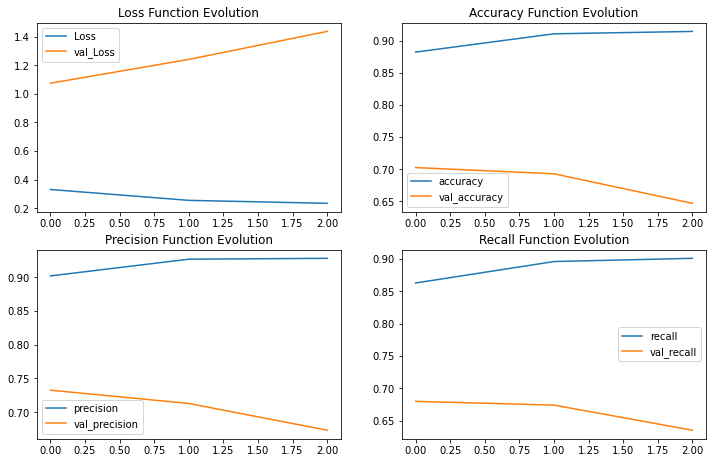

In [14]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [15]:
evaluation = model.evaluate(x_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

49/49 [==============================] - 0s 5ms/step - loss: 1.4356 - accuracy: 0.6471 - precision: 0.6733 - recall: 0.6354
Test Accuracy : 64.71%


In [16]:
rounded_labels = np.argmax(y_test, axis=1)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(rounded_labels, y_pred)

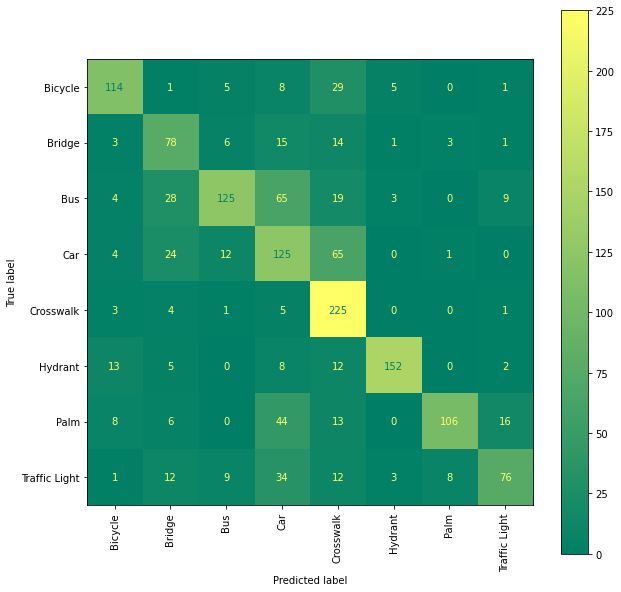

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [18]:
print(classification_report(rounded_labels, y_pred, target_names=labels))

               precision    recall  f1-score   support

      Bicycle       0.76      0.70      0.73       163
       Bridge       0.49      0.64      0.56       121
          Bus       0.79      0.49      0.61       253
          Car       0.41      0.54      0.47       231
    Crosswalk       0.58      0.94      0.72       239
      Hydrant       0.93      0.79      0.85       192
         Palm       0.90      0.55      0.68       193
Traffic Light       0.72      0.49      0.58       155

     accuracy                           0.65      1547
    macro avg       0.70      0.64      0.65      1547
 weighted avg       0.70      0.65      0.65      1547

